In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.load.*weights_only=False.*")

import time

import torch
from _dattri.utlis import compute_pairwise_distance_metrics, compute_pairwise_inner_product_rank_correlation
import matplotlib.pyplot as plt

# First, check if CUDA is available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:1


In [2]:
projection_dims = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

def test_random_projection_quality(projection_dims, batch_size=100, original_dim=4096, sparsity_levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], mode="sparse"):
    # Store results for each sparsity level
    relative_errors_dist = {sparsity: [] for sparsity in sparsity_levels}
    spearman_correlations = {sparsity: [] for sparsity in sparsity_levels}
    times = {sparsity: [] for sparsity in sparsity_levels}

    for sparsity in sparsity_levels:
        # Create a batch of random vectors
        rand_vec = torch.randn(batch_size, original_dim, device=device).float()

        # Sparsify the vectors by randomly setting a fraction (sparsity) of elements to zero
        num_elements_to_drop = int(sparsity * original_dim)
        if num_elements_to_drop > 0:
            for i in range(batch_size):
                indices_to_drop = torch.randperm(original_dim)[:num_elements_to_drop]
                rand_vec[i, indices_to_drop] = 0

        for proj_dim in projection_dims:
            rand_vec_p = torch.zeros(batch_size, proj_dim).float().to(device)

            start_time = time.time()

            if mode == "sparse":
                delta = 1 - 5e-7
                eps = None

                # Handle delta and eps
                if delta is None and eps is not None:
                    delta = 1 / torch.exp(torch.tensor(proj_dim * eps**2 / 12))
                elif eps is None and delta is not None:
                    eps = torch.sqrt(12 * torch.log(torch.tensor(1 / delta)) / proj_dim)
                else:
                    raise ValueError("Either delta or eps must be provided.")

                # Calculate the number of non-zero projections per vector element
                c = int(16 * torch.log(torch.tensor(1 / delta)) * (torch.log(torch.tensor(proj_dim / delta)) ** 2) / eps)
                print(proj_dim, c)

                rand_indices = torch.randint(proj_dim, (original_dim, c), device=rand_vec.device)
                rand_signs = torch.randint(0, 2, (original_dim, c), device=rand_vec.device) * 2 - 1

                # for i in range(batch_size):  # Apply sparse random projection
                #     vec = rand_vec[i]
                #     non_zero_indices = torch.nonzero(vec).squeeze()
                #     # if non_zero_indices.numel() == 0:
                #     #     rand_vec_p[i] = torch.zeros(proj_dim, device=vec.device)
                #     #     continue

                #     # Multiply the non-zero elements of vec by their corresponding random signs
                #     scaled_vals = vec[non_zero_indices].unsqueeze(1) * rand_signs[non_zero_indices]  # Shape (num_non_zero, c_int)

                #     # Perform vectorized index addition using scatter_add for better performance
                #     rand_vec_p[i].scatter_add_(0, rand_indices[non_zero_indices].flatten(), scaled_vals.flatten()) / (c ** 0.5)

                for i in range(batch_size): # Apply sparse random projection
                    vec = rand_vec[i]
                    non_zero_indices = torch.nonzero(vec).squeeze()
                    if non_zero_indices.numel() == 0:
                        return torch.zeros(proj_dim, device=vec.device)

                    # Multiply the non-zero elements of vec by their corresponding random signs
                    scaled_vals = vec[non_zero_indices].unsqueeze(1) * rand_signs[non_zero_indices] # Shape (num_non_zero, c_int)

                    vec_p = torch.zeros(proj_dim, device=vec.device)

                    # Perform vectorized index addition (summing over c_int for each non-zero element)
                    vec_p.index_add_(0, rand_indices[non_zero_indices].flatten(), scaled_vals.flatten())
                    rand_vec_p[i] = vec_p / (c ** 0.5)
            else:
                # Using classical JL lemma
                proj_matrix = torch.randn(proj_dim, original_dim, device=rand_vec.device) / (proj_dim ** 0.5)

                # non-batched version for a fair comparison
                for i in range(batch_size):
                    rand_vec_p[i] = proj_matrix @ rand_vec[i]

                # batched version
                # rand_vec_p = rand_vec @ proj_matrix.T

            end_time = time.time()

            # Calculate relative error for the current projection dimension
            relative_error = compute_pairwise_distance_metrics(rand_vec, rand_vec_p)
            relative_errors_dist[sparsity].append(relative_error)

            # Calculate Spearman rank correlation for inner products
            spearman_corr = compute_pairwise_inner_product_rank_correlation(rand_vec, rand_vec_p)
            spearman_correlations[sparsity].append(spearman_corr)

            # Record the time taken
            times[sparsity].append(end_time - start_time)

    # Plotting relative errors for each sparsity level
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))

    # Plotting relative errors for each sparsity level on the first subplot
    ax = axes[0]
    for sparsity in sparsity_levels:
        ax.plot(projection_dims, relative_errors_dist[sparsity], marker='o', label=f'Sparsity: {sparsity}')
    ax.set_xticks(projection_dims)
    ax.set_title("Relative Error Between Pairwise Distances vs. Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Relative Error (Mean)")
    ax.legend()

    # Plotting Spearman rank correlations for each sparsity level on the second subplot
    ax = axes[1]
    for sparsity in sparsity_levels:
        ax.plot(projection_dims, spearman_correlations[sparsity], marker='o', label=f'Sparsity: {sparsity}')
    ax.set_xticks(projection_dims)
    ax.set_title("Spearman Rank Correlation of Pairwise Inner Products vs. Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Spearman Rank Correlation")
    ax.legend()

    # Plotting computation times for each sparsity level on the third subplot
    ax = axes[2]
    for sparsity in sparsity_levels:
        ax.plot(projection_dims, times[sparsity], marker='o', label=f'Sparsity: {sparsity}')
    ax.set_xticks(projection_dims)
    ax.set_title("Computation Time vs. Projection Dimension")
    ax.set_xlabel("Projection Dimension")
    ax.set_ylabel("Time (seconds)")
    ax.legend()

    # Adjust layout so plots do not overlap
    plt.tight_layout()
    plt.show()

64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38
64 0
128 0
256 1
512 2
1024 4
2048 8
4096 14
8192 23
16384 38


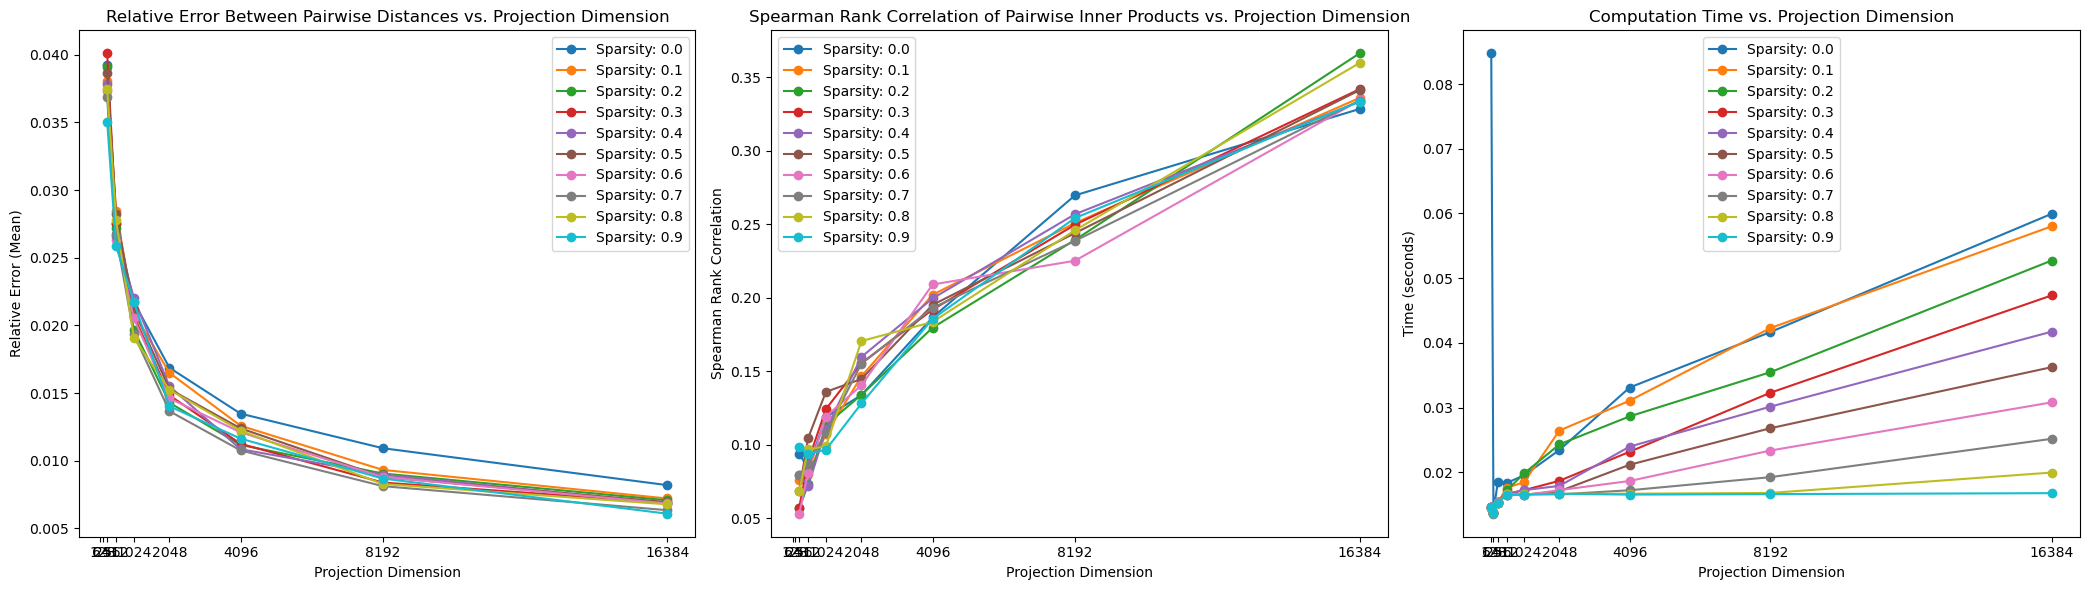

In [3]:
test_random_projection_quality(projection_dims, original_dim=8192*16)

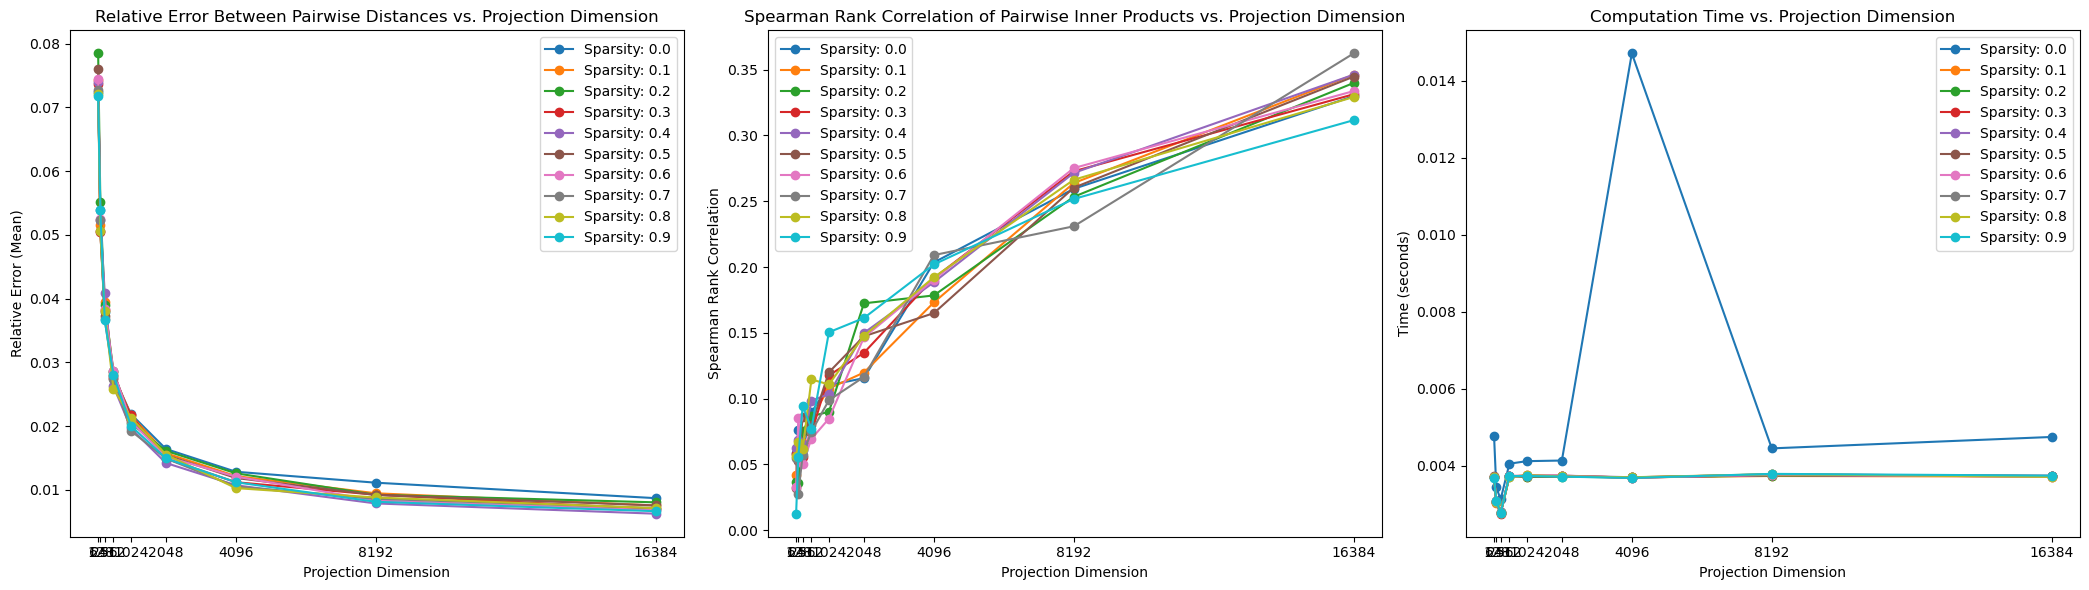

In [4]:
test_random_projection_quality(projection_dims, original_dim=8192*16, mode="dense")